# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import *

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [2]:
# YOUR CODE HERE
from common_utils import MLP
from common_utils import CustomDataset
from common_utils import loss_fn
from common_utils import split_dataset, preprocess_dataset
from common_utils import EarlyStopper
from datetime import datetime
df_sim = pd.read_csv('simplified.csv')
df_sim['label'] = df_sim['filename'].str.split('_').str[-2]
df_sim['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df_sim, ['filename', 'label'], 0.3, 0)
df_sim

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,label
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803,0
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572,0
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824,0
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389,0
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12052,app_3057_4113_phnd_pos_0022.wav,86.132812,1605,160.500000,0.549566,0.078633,0.438854,0.078327,0.258500,0.016511,...,67.892044,3.546391,49.891026,-3.597707,70.953079,-2.672421,62.369473,-3.812236,47.410625,1
12053,app_3057_4113_phnd_pos_0023.wav,184.570312,3037,168.722222,0.584372,0.074350,0.478900,0.078894,0.258216,0.016658,...,63.430107,3.869859,52.517521,-1.637068,59.811417,-3.041467,55.640205,-5.101839,43.080894,1
12054,app_3057_4113_phnd_pos_0024.wav,143.554688,1549,129.083333,0.541845,0.088258,0.441677,0.080670,0.261484,0.014959,...,79.961853,3.689087,68.597672,-1.665412,70.761398,0.218386,86.220604,-4.678007,85.629585,1
12055,app_3057_4113_phnd_pos_0025.wav,143.554688,8820,284.516129,0.532886,0.089102,0.469113,0.077342,0.265298,0.012950,...,80.636742,2.619849,63.592182,-0.559597,62.905022,0.256377,56.687534,-3.086725,62.594326,1


2. Install and import shap

In [3]:
# YOUR CODE HERE
import shap

3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [4]:
df = pd.read_csv('new_record.csv')
size_row = 0
size_column = 0
# YOUR CODE HERE
size_row, size_column = df.shape

 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [5]:

def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    # YOUR CODE HERE
    standard_scaler = preprocessing.StandardScaler()
    df_new = df.drop(['filename'], axis = 1)
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_test_scaled_eg = standard_scaler.transform(df_new)

    return df_new, X_train_scaled, X_test_scaled_eg

df_new, X_train_scaled, X_test_scaled_eg = preprocess(X_train, df)
X_test_scaled_eg

array([[-2.73712628e-01, -8.92799314e-01, -1.49261765e+00,
        -1.36015611e+00,  2.07550976e+00,  1.80226262e+00,
         1.40764467e+00,  8.95544384e-01, -9.07694115e-01,
        -5.32370192e-01, -3.02974203e-01, -3.10532279e+00,
         3.28373800e+00,  3.75335937e-01,  2.30938378e+00,
        -9.99080051e-01, -7.66492606e-02,  1.33713246e+00,
         4.09313941e+00,  1.48814851e+00,  1.80322599e+01,
        -5.04299522e+00, -4.27258782e+00,  1.30403458e+00,
         1.30403458e+00, -1.12252014e+00, -1.12252014e+00,
        -1.19767410e+00, -1.24517280e+00,  1.41662905e+00,
         1.30213494e+00,  5.16579237e-02, -8.06896787e-01,
        -7.10415155e-01,  6.29920468e-02, -1.15538054e+00,
        -9.45651064e-01, -3.09280536e+00,  2.20261274e+00,
        -4.17181342e+00,  3.24048070e+00,  1.25496260e+00,
         2.03102711e+00, -2.18047302e+00,  9.40526082e-01,
         1.01561446e+00, -7.35425939e-01, -1.12877717e+00,
         2.98443450e-01,  3.30241627e-01,  5.01976497e-0

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [6]:
# YOUR CODE HERE
model = torch.load('pretrained_model.pth')
model.eval()
pred = model(torch.tensor(X_test_scaled_eg, dtype=torch.float))
if pred >= 0.5:
    pred_label = "pos"
else:
    pred_label = "neg"

print(pred.item())
print(pred_label)

0.9370472431182861
pos


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


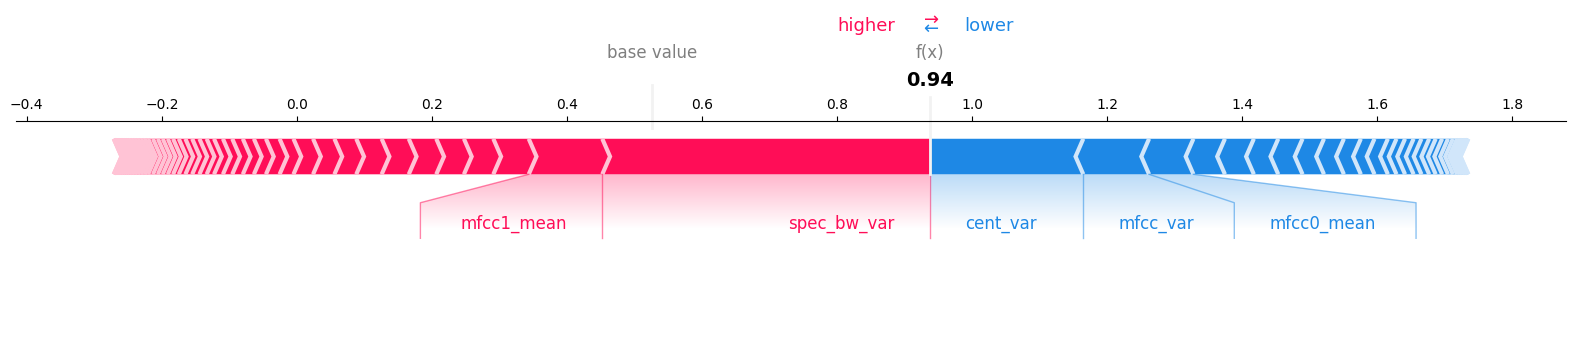

In [9]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
explainer = shap.DeepExplainer(model, torch.tensor(X_train_scaled, dtype=torch.float))
shap_values = explainer.shap_values(torch.tensor(X_test_scaled_eg, dtype=torch.float))
shap.force_plot(explainer.expected_value[0], shap_values[0], features= df_new.columns, matplotlib=True)
explaination = "The biggest positive contributor is spec_bw_var while the biggest negative contributor is cent_var"